<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/practica_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 7: Modelos de regresión Normal parte 2

En esta práctica se verán ejemplos de regresión Normal lineal con múltiples variables predictoras. Incluyendo variables categóricas e interacciones.

Se verá también algunos ejemplos de inferencia causal.

Se verá también ejemplo de distintos gráficos para la evaluación del ajuste.

Se van a requerir las siguientes librerías en esta clase.

In [1]:
import io
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install pymc
import pymc as pm
import arviz as az
import pandas as pd

## Datasets

En esta práctica vamos a usar los siguientes datasets.

### Dataset 1: Resistencia de una mezcla de hormigón

fuente: https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Concrete_Data.csv to Concrete_Data.csv


In [3]:
#Se crea un DataFrame
df_hormigon = pd.read_csv(io.BytesIO(uploaded['Concrete_Data.csv']))
df_hormigon.head()

,Cement (kg/m3),Blast Furnace Slag (kg/m3),Fly Ash (kg/m3),Water (kg/m3),Superplasticizer (kg/m3),Coarse Aggregate (kg/m3),Fine Aggregate (kg/m3),Age (day),Concrete compressive strength (MPa)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


### Dataset 2: Frecuencia natural de galpones industriales

fuente: Santiago Bertero, Virginia Tech

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Galpones.csv to Galpones.csv


In [5]:
#Se crea un DataFrame
df_galpones = pd.read_csv(io.BytesIO(uploaded['Galpones.csv']))
df_galpones.head()

,Frame,W_kip_,Height_in_,L_ft_,alpha,Cladding,Structure,Roof,Seismic,Wind,Weights,k_lat_kip_ft_,MassParticipation,T_model_s_,T_r1_s_,T_r2_s_,T_S_U_s_
0,1,10.21,190.0,40,2.526,Metal Panels,Clear Span,Monoslope,Low,High,0.011666,3.520,0.933,0.546,0.546,0.545,0.707386
1,2,25.16,192.5,100,6.234,Metal Panels,Clear Span,Gabled,Low,High,0.032986,12.459,0.619,0.571,0.560,0.454,0.537498
2,3,46.71,220.0,160,8.727,Metal Panels,Clear Span,Monoslope,High,High,0.001667,27.663,0.423,0.606,0.580,0.415,0.423907
3,4,13.14,400.0,40,1.200,Metal Panels,Clear Span,Gabled,Low,High,0.002174,3.563,0.930,0.602,0.602,0.614,0.953937
4,5,52.23,385.0,100,3.117,Metal Panels,Clear Span,Monoslope,High,Low,0.001058,7.218,0.925,0.881,0.880,0.860,1.208260


### Dataset 3: Punzonado en losas

fuente: Maya et al (2012), Punching shear strength of steel fibre reinforced concrete slabs (DOI 10.1016/j.engstruct.2012.02.009)

In [6]:
from google.colab import files
uploaded = files.upload()

Saving punching_shear_slabs_Maya2012.csv to punching_shear_slabs_Maya2012.csv


In [7]:
#Se crea un DataFrame
df_punzonado = pd.read_csv(io.BytesIO(uploaded['punching_shear_slabs_Maya2012.csv']))
df_punzonado.head()

,Specimen,h(mm),d(mm),bca(mm),fc(MPa),rho(%),rhof(%),Vexp(kN),VexpVR/est1b,VexpVR/est2c,VexpVR/d-d
0,S1,152,127.0,152,47.7,0.98,0.0,433.0,1.10,1.19,1.38
1,S2,152,127.0,152,47.7,0.66,0.0,379.0,1.16,1.22,1.42
2,S3/FRC,152,127.0,152,25.4,0.98,1.0,386.0,1.01,1.09,1.25
3,S4/FRC,152,127.0,152,25.4,0.66,1.0,389.0,1.15,1.20,1.37
4,S5/FRM,152,127.0,152,59.3,0.98,1.5,530.0,1.03,1.12,1.27


## Ejemplo 0: Resistencia del hormigón versus cantidad de cemento

In [8]:
x = df_hormigon['Cement (kg/m3)']
x = (x-x.mean())/x.std()
y = df_hormigon['Concrete compressive strength (MPa) ']
y = (y-y.mean())/y.std()

In [9]:
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )

    # Posterior de los parámetros
    trace = pm.sample( 3000, tune=2000, cores=2 )
    
    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace, extend_inferencedata=True )

In [10]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

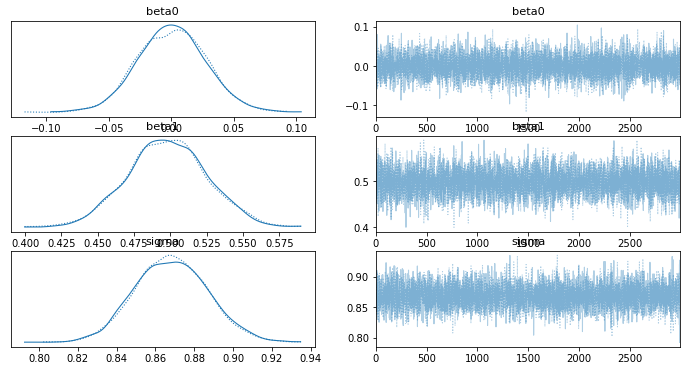

In [11]:
az.plot_trace( trace, var_names=['~mu'] );

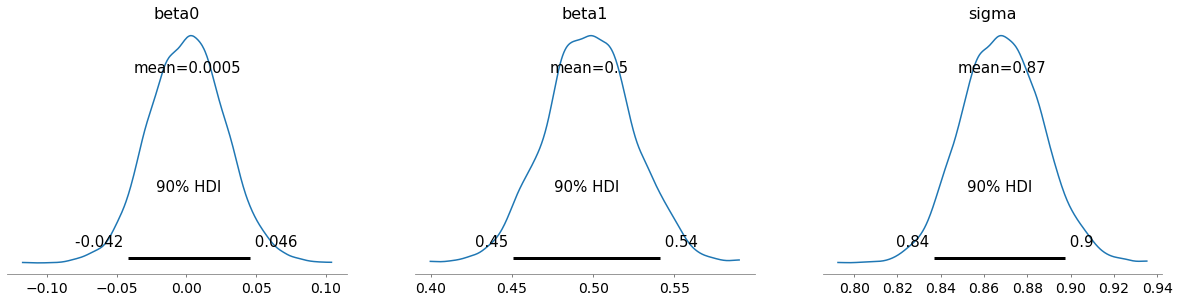

In [12]:
az.plot_posterior( trace, var_names=['~mu'], hdi_prob=0.9 );

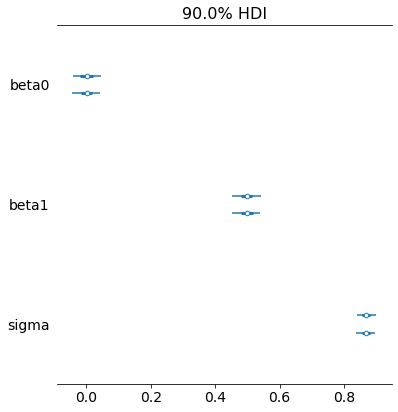

In [13]:
az.plot_forest( trace, var_names=['~mu'], hdi_prob=0.9 );

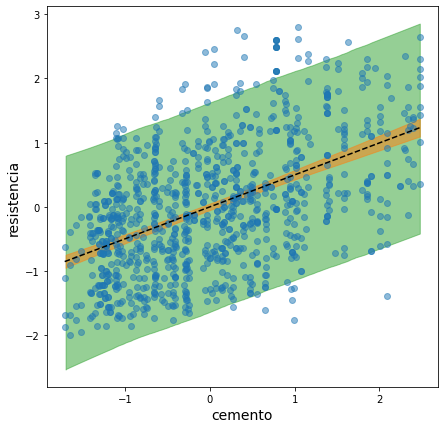

In [14]:
fig, ax = plt.subplots( figsize=(7,7) )

# Línea media
ix = np.argsort(x).to_numpy()
ax.plot( x[ix], trace.posterior['mu'].mean(['chain','draw'])[ix],'k--')

# HDI de observaciones
az.plot_hdi( x, trace.posterior_predictive['y'], color='C2', ax=ax )

# HDI de mu
az.plot_hdi( x, trace.posterior['mu'], color='C1', ax=ax )

# Observaciones
ax.scatter( x, y, alpha=.5 )

# Formateo
ax.set_xlabel('cemento', fontsize=14)
ax.set_ylabel('resistencia', fontsize=14);

## Ejemplo 1: resistencia del hormigón vs cemento y escoria

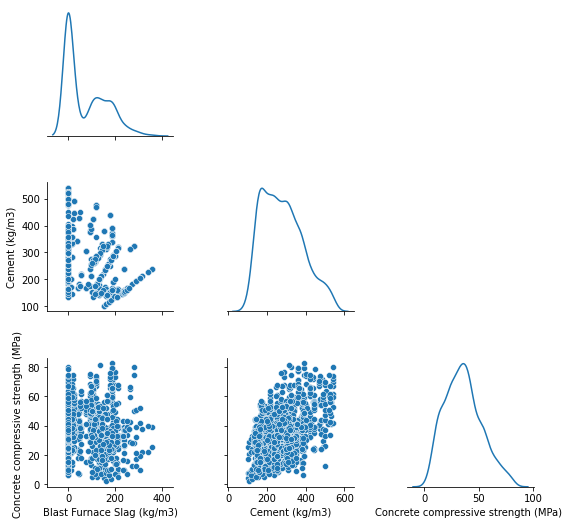

In [15]:
g = sns.PairGrid(df_hormigon, diag_sharey=False, corner=True,
                 vars=['Blast Furnace Slag (kg/m3)',
                       'Cement (kg/m3)',
                       'Concrete compressive strength (MPa) '])
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend();

In [16]:
df_hormigon.columns

Index(['Cement (kg/m3)', 'Blast Furnace Slag (kg/m3)', 'Fly Ash (kg/m3)',
       'Water  (kg/m3)', 'Superplasticizer (kg/m3)',
       'Coarse Aggregate  (kg/m3)', 'Fine Aggregate (kg/m3)', 'Age (day)',
       'Concrete compressive strength (MPa) '],
      dtype='object')

In [17]:
x1 = df_hormigon['Cement (kg/m3)']
x1 = (x1-x1.mean())/x1.std()
x2 = df_hormigon['Blast Furnace Slag (kg/m3)']
x2 = (x2-x2.mean())/x2.std()
y = df_hormigon['Concrete compressive strength (MPa) ']
y = (y-y.mean())/y.std()

In [18]:
# modelo solo con x1
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1 = pm.sample( 3000, tune=2000, cores=2 )
    
    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_x1, extend_inferencedata=True )

In [19]:
# Modelo solo con x2
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta2 * x2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x2 = pm.sample( 3000, tune=2000, cores=2 )
    
    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_x2, extend_inferencedata=True )

In [20]:
# modelo con x1 y x2
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 + beta2 * x2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1x2 = pm.sample( 3000, tune=2000, cores=2 )
    
    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_x1x2, extend_inferencedata=True )

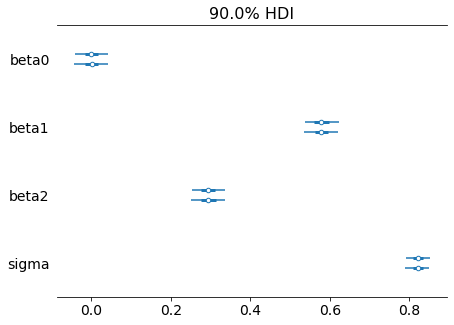

In [21]:
az.plot_forest( trace_x1x2, var_names=['~mu'],
                figsize=(7,5), textsize=14, hdi_prob=0.9 );

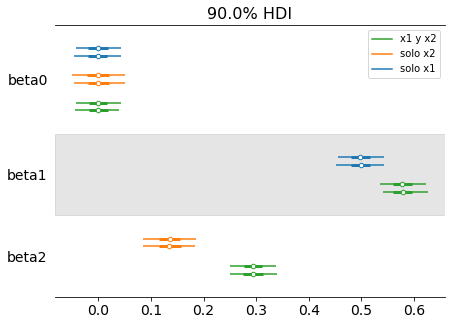

In [ ]:
az.plot_forest( [trace_x1,trace_x2,trace_x1x2], var_names=['~mu','~sigma'],
                model_names=['solo x1','solo x2','x1 y x2'],
                figsize=(7,5), textsize=14, hdi_prob=0.9 );

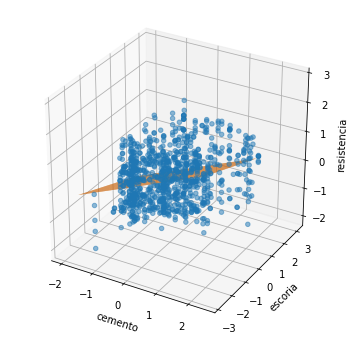

In [ ]:
# Valores medios de los parámetros
beta_mean = trace_x1x2.posterior.mean(['chain','draw'])

# Malla 2d
x1_grid, x2_grid = np.meshgrid( np.arange(-2,2,0.1), np.arange(-2,2,0.1) )

# Plano medio
mu_mean = beta_mean.beta0.item() + beta_mean.beta1.item()*x1_grid + \
          beta_mean.beta2.item()*x2_grid

# Gráfico
fig = plt.figure( figsize=(6,6) )
ax = fig.add_subplot(111, projection='3d')
ax.scatter( x1, x2, y, alpha=.5 )
ax.plot_surface( x1_grid, x2_grid, mu_mean, color='C1' )

ax.set_xlabel('cemento')
ax.set_ylabel('escoria')
ax.set_zlabel('resistencia');

## Ejemplo 2: resistencia del hormigón vs cemento y edad

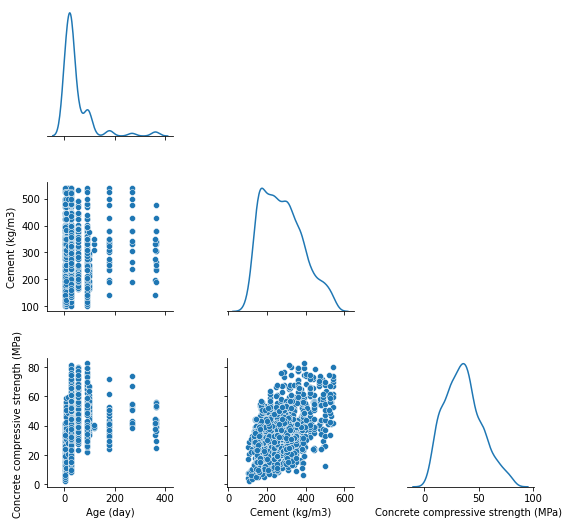

In [22]:
g = sns.PairGrid(df_hormigon, diag_sharey=False, corner=True,
                 vars=['Age (day)',
                       'Cement (kg/m3)',
                       'Concrete compressive strength (MPa) '])
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend();

In [23]:
x1 = df_hormigon['Cement (kg/m3)']
x1 = (x1-x1.mean())/x1.std()
x2 = df_hormigon['Age (day)']
x2 = (x2-x2.mean())/x2.std()
y = df_hormigon['Concrete compressive strength (MPa) ']
y = (y-y.mean())/y.std()

In [24]:
# modelo solo con x1
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 )  
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_x1, extend_inferencedata=True )

In [25]:
# modelo solo con x2 (sin término cuadrático)
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2, shape=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta2[0] * x2 )  
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x2 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_x2, extend_inferencedata=True )

In [26]:
# modelo con x1 y x2 con término cuadrático
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2, shape=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 + beta2[0] * x2 + beta2[1] * x2**2 )  
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1x2 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_x1x2, extend_inferencedata=True )

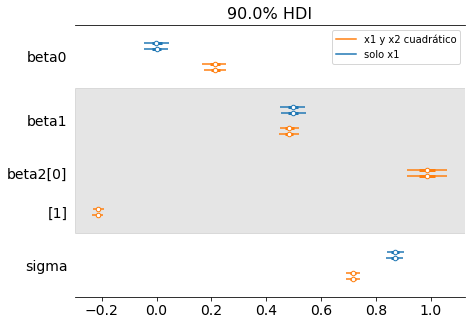

In [27]:
az.plot_forest( [trace_x1,trace_x1x2], var_names=['~mu'],
                model_names=['solo x1', 'x1 y x2 cuadrático'],
                figsize=(7,5), textsize=14, hdi_prob=0.9 );

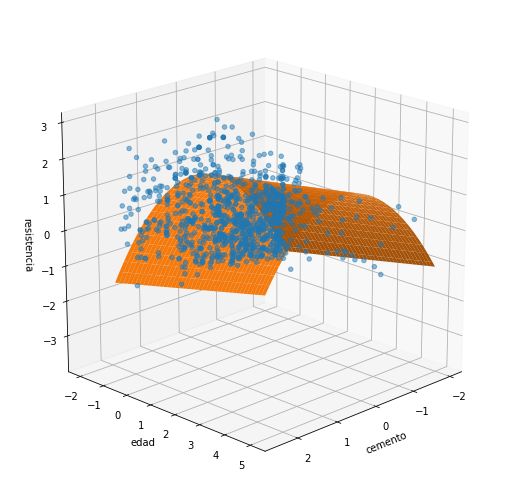

In [28]:
# Valores medios de los parámetros
beta_mean = trace_x1x2.posterior.mean(['chain','draw'])

# Malla 2d
x1_grid, x2_grid = np.meshgrid( np.arange(-2,2,0.1), np.arange(-2,5,0.1) )

# Plano medio
mu_mean = beta_mean.beta0.item() + beta_mean.beta1.item()*x1_grid + \
          beta_mean.beta2[0].item()*x2_grid + beta_mean.beta2[1].item()*x2_grid**2

# Gráfico
fig = plt.figure( figsize=(9,9) )
ax = fig.add_subplot(111, projection='3d')
ax.scatter( x1, x2, y, alpha=.5 )
ax.plot_surface( x1_grid, x2_grid, mu_mean, color='C1' )

ax.view_init(elev=20, azim=45)
ax.set_xlabel('cemento')
ax.set_ylabel('edad')
ax.set_zlabel('resistencia');

In [31]:
# Cálculo de residuos

# Lineas medias
mu_pred = trace_x2.posterior['mu'].stack(sample=("chain", "draw")).to_numpy()

# Residuos
residuals = y.to_numpy() - mu_pred.T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  import sys


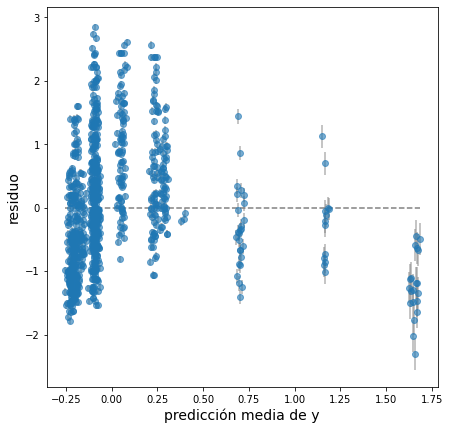

In [32]:
# Residuos vs predicción media

# Predicción posterior media de y
y_mean = trace_x2.posterior_predictive['y'].mean( ['chain','draw'] ).to_numpy()

# Intervalos de confianza
residuals_hdi = az.hdi( residuals, hdi_prob=0.9 )
residuals_mean = np.mean( residuals, 0 );

# Gráfico
fig, ax = plt.subplots( figsize=(7,7) )
ax.hlines( y=0, xmin=y_mean.min(), xmax=y_mean.max(),
            colors='grey', linestyle='--' )
ax.errorbar( y_mean, residuals_mean,
             yerr=np.abs(residuals_mean-residuals_hdi.T ),
             fmt='C0o',
             ecolor='grey', alpha=.6 )

# Formateo
ax.set_xlabel('predicción media de y', fontsize=14)
ax.set_ylabel('residuo', fontsize=14);

## Ejemplo 3: Resistencia del hormigón vs presencia de superplastificante

En este caso, usamos el Dataset #1, para predecir la distribución de probabilidad de la resistencia de la mezcla usando la presencia de superplastificante como predictor.

In [33]:
df_hormigon['superpl_presencia'] = 1*(df_hormigon['Superplasticizer (kg/m3)']>0)
df_hormigon.head()

,Cement (kg/m3),Blast Furnace Slag (kg/m3),Fly Ash (kg/m3),Water (kg/m3),Superplasticizer (kg/m3),Coarse Aggregate (kg/m3),Fine Aggregate (kg/m3),Age (day),Concrete compressive strength (MPa),superpl_presencia
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,1
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,1
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,0


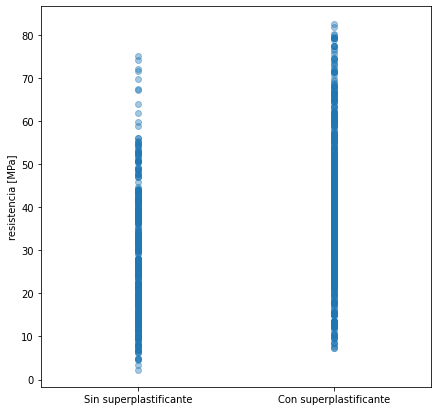

In [34]:
# Crear ejes
fig, ax = plt.subplots( figsize=(7,7) )

# Graficar observaciones
ax.scatter( df_hormigon['superpl_presencia'], 
            df_hormigon['Concrete compressive strength (MPa) '], alpha=.4 )

# Formatear gráfico
ax.set_xlim([-0.5,1.5])
ax.set_xticks([0,1])
ax.set_ylabel('resistencia [MPa]')
ax.set_xticklabels(['Sin superplastificante','Con superplastificante']);

In [35]:
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal("beta0", mu=30, sigma=5)
    beta1 = pm.Normal("beta1", mu=0, sigma=5)
    sigma = pm.Exponential( "sigma", 1 )
    
    # Valor medio
    mu = pm.Deterministic( 'mu', beta0 + beta1 * df_hormigon['superpl_presencia'] )
    mu_x1 = pm.Deterministic( 'mu_x1', beta0 + beta1 ) # para que quede calculado dentro de trace
    
    # Observaciones
    Y = pm.Normal( "y", mu=mu, sigma=sigma,
                   observed=df_hormigon['Concrete compressive strength (MPa) '] )
      
    # Simulación de la Posterior de los parámetros
    trace = pm.sample( 3000, tune=1000, cores=2 )

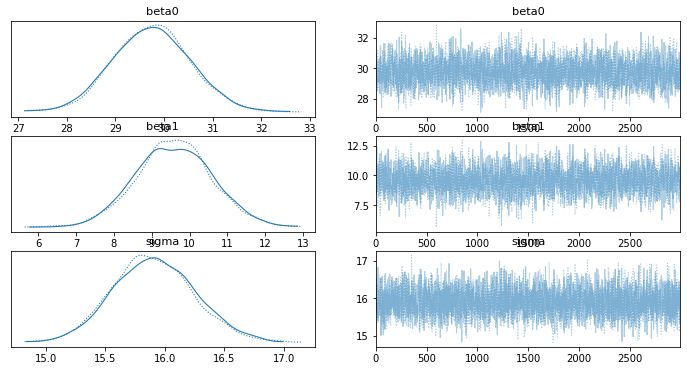

In [36]:
# Chequeo de convergencia de cadenas de Markov
az.plot_trace( trace, var_names=['~mu','~mu_x1'] );

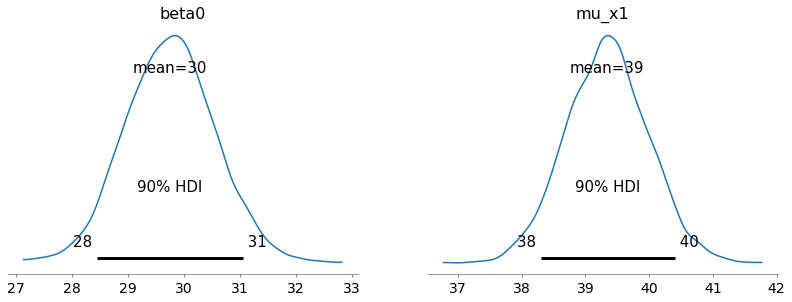

In [37]:
# Ploteamos distribución posterior de los parámetros
az.plot_posterior( trace, var_names=['beta0','mu_x1'], hdi_prob=0.9 );

In [38]:
# Simulación posterior predictiva
with model:
    pm.sample_posterior_predictive( trace, extend_inferencedata=True )

1
0


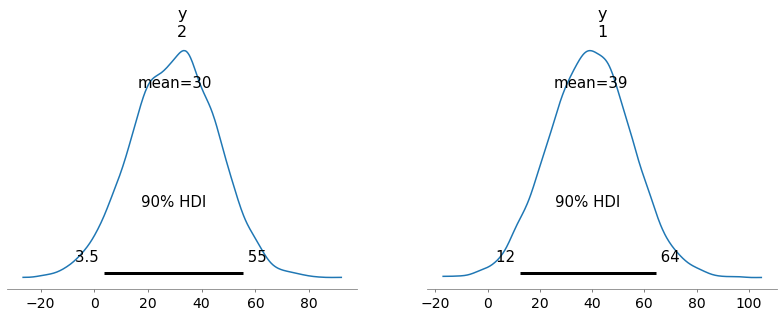

In [39]:
# Predicción posterior del valor medio
i_x1 = 1 # índice de observación con x=0
print( df_hormigon['superpl_presencia'][i_x1] )
i_x0 = 2 # índice de observación con x=0
print( df_hormigon['superpl_presencia'][i_x0] )
# Distribución posterior
az.plot_posterior( trace, group='posterior_predictive', var_names=['y'],
                   coords={'y_dim_0': [i_x0, i_x1]}, hdi_prob=0.90 );

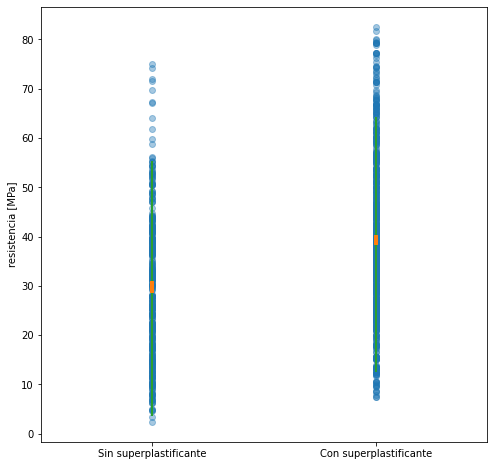

In [40]:
# Ploteamos la posterior del valor medio
fig, ax = plt.subplots( figsize=(8,8) )

# Observaciones
ax.scatter( df_hormigon['superpl_presencia'],
            df_hormigon['Concrete compressive strength (MPa) '],
            alpha=.4 )

# Intervalos de confianza posteriores de y
y_post_sum = az.summary( trace, group='posterior_predictive', var_names=['y'],
                         coords={'y_dim_0': [i_x0, i_x1]}, hdi_prob=0.90 );
ax.vlines( x=0, 
           ymin=y_post_sum.loc['y[2]']['hdi_5%'], 
           ymax=y_post_sum.loc['y[2]']['hdi_95%'],
           color='C2',
           linewidth=2
           )
ax.vlines( x=1, 
           ymin=y_post_sum.loc['y[1]']['hdi_5%'], 
           ymax=y_post_sum.loc['y[1]']['hdi_95%'],
           color='C2',
           linewidth=2
           )

# Intervalos de confianza posteriores de mu
mu_post_sum = az.summary( trace, group='posterior', var_names=['mu'],
                          coords={'mu_dim_0': [i_x0, i_x1]}, hdi_prob=0.90 )
ax.vlines( x=0, 
           ymin=mu_post_sum.loc['mu[2]']['hdi_5%'], 
           ymax=mu_post_sum.loc['mu[2]']['hdi_95%'],
           color='C1',
           linewidth=4
           )
ax.vlines( x=1, 
           ymin=mu_post_sum.loc['mu[1]']['hdi_5%'], 
           ymax=mu_post_sum.loc['mu[1]']['hdi_95%'],
           color='C1',
           linewidth=4
           )

# Formateo de gráfico
ax.set_xlim([-0.5,1.5])
ax.set_xticks([0,1])
ax.set_ylabel('resistencia [MPa]')
ax.set_xticklabels(['Sin superplastificante','Con superplastificante']);

## Ejemplo 4: Período natural de galpones versus tipologia estructural

En este caso usamos el Dataset #2, que contiene la frecuencia natural medida del 1er modo de vibración para galpones de distintas dimensiones y tipologías estructurales.

La tipología estructural del galpón puede considerarse una variable categórica que sirve para mejorar la predicción de su frecuencia natural

In [41]:
# Creamos nueva columna de tipología de tipo categórica
df_galpones['tipologia'] = df_galpones['Cladding'] + '\n' + df_galpones['Structure']
df_galpones['tipologia'] = df_galpones['tipologia'].astype('category')

# Creamos una nueva columna asignándole un número entero a cada tipología
cat_codes = {'Metal Panels\nClear Span': 0, 'Concrete\nClear Span': 1,
             'Metal Panels\nModular': 2, 'Concrete\nModular': 3}
df_galpones['tipologia_cod'] = df_galpones['tipologia'].cat.rename_categories( cat_codes )

df_galpones.head()

,Frame,W_kip_,Height_in_,L_ft_,alpha,Cladding,Structure,Roof,Seismic,Wind,Weights,k_lat_kip_ft_,MassParticipation,T_model_s_,T_r1_s_,T_r2_s_,T_S_U_s_,tipologia,tipologia_cod
0,1,10.21,190.0,40,2.526,Metal Panels,Clear Span,Monoslope,Low,High,0.011666,3.520,0.933,0.546,0.546,0.545,0.707386,Metal Panels\nClear Span,0
1,2,25.16,192.5,100,6.234,Metal Panels,Clear Span,Gabled,Low,High,0.032986,12.459,0.619,0.571,0.560,0.454,0.537498,Metal Panels\nClear Span,0
2,3,46.71,220.0,160,8.727,Metal Panels,Clear Span,Monoslope,High,High,0.001667,27.663,0.423,0.606,0.580,0.415,0.423907,Metal Panels\nClear Span,0
3,4,13.14,400.0,40,1.200,Metal Panels,Clear Span,Gabled,Low,High,0.002174,3.563,0.930,0.602,0.602,0.614,0.953937,Metal Panels\nClear Span,0
4,5,52.23,385.0,100,3.117,Metal Panels,Clear Span,Monoslope,High,Low,0.001058,7.218,0.925,0.881,0.880,0.860,1.208260,Metal Panels\nClear Span,0


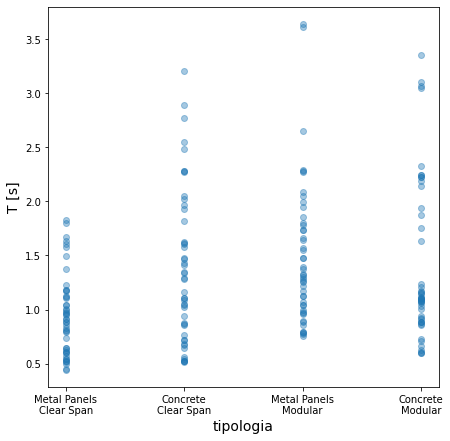

In [42]:
# Crear ejes
fig, ax = plt.subplots( figsize=(7,7) )

# Graficar observaciones
ax.scatter( df_galpones['tipologia'], 
            df_galpones['T_model_s_'], alpha=.4 );

# Formateo
ax.set_xlabel('tipologia', fontsize=14)
ax.set_ylabel('T [s]', fontsize=14);

In [43]:
# Modelo con variable categórica como variable continua
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal("beta0", mu=1, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic( 'mu', beta0 + beta1*df_galpones['tipologia_cod'] )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=df_galpones['T_model_s_'] )
      
    # Posterior de los parámetros
    trace = pm.sample( 3000, tune=1000, cores=2 )

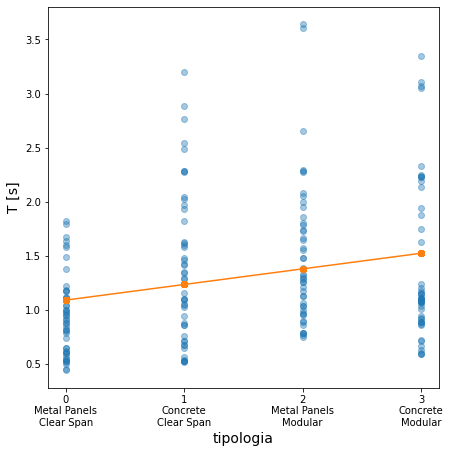

In [45]:
# Valor medio de las distribuciones posteriores de mu
mu_mean = trace.posterior.mu.mean( ['chain','draw'] )

# Plotear
fig, ax = plt.subplots( figsize=(7,7) )
ax.scatter( df_galpones['tipologia_cod'], df_galpones['T_model_s_'], alpha=.4 )

# Punto medio de la distribución posterior
ax.plot( df_galpones['tipologia_cod'], mu_mean, color='C1', marker='o' );

# Formateo del gráfico
ticks = [0,1,2,3]
ax.set_xticks(ticks)
cats_sorted = dict(sorted(cat_codes.items(), key=lambda item: item[1]))
ax.set_xticklabels([str(ticks[i])+'\n'+list(cats_sorted.keys())[i] for i in range(4)])
ax.set_xlabel('tipologia', fontsize=14)
ax.set_ylabel('T [s]', fontsize=14);

#### Variable índice

Lo ideal es considerar a la variable categórica como variable índice

- Mejor interpretabilidad de los parámetros
- Facilidad para definir distribuciones a priori

In [46]:
# variable categórica como variable índice
with pm.Model() as model:
    
    # Priors
    beta = pm.Normal("beta", mu=1, sigma=1, shape=4)
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic( 'mu', beta[ df_galpones['tipologia_cod'] ] )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=df_galpones['T_model_s_'] )
      
    # Posterior de los parámetros
    trace = pm.sample( 3000, tune=1000, cores=2 )

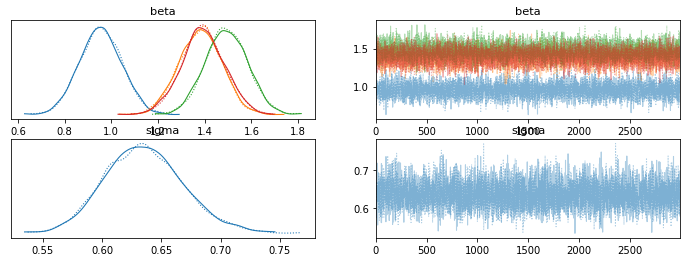

In [47]:
# Chequeo de convergencia de cadenas de Markov
az.plot_trace( trace, var_names=['~mu'] );

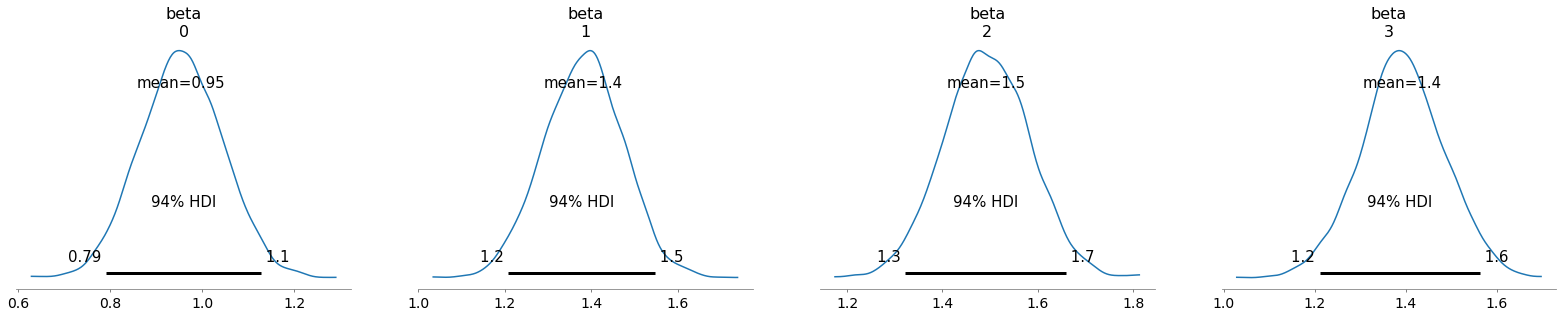

In [48]:
# Chequeo de convergencia de cadenas de Markov
az.plot_posterior( trace, var_names=['~mu','~sigma'] );

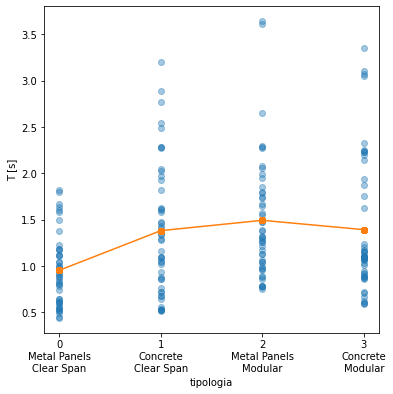

In [49]:
# Valor medio de las distribuciones posteriores de mu
mu_mean = trace.posterior.mu.mean( ['chain','draw'] )

# Plotear
fig, ax = plt.subplots( figsize=(6,6) )
ax.scatter( df_galpones['tipologia_cod'], df_galpones['T_model_s_'], alpha=.4 )

# Punto medio de la distribución posterior
ax.plot( df_galpones['tipologia_cod'], mu_mean, color='C1', marker='o' );

# Formateo del gráfico
ticks = [0,1,2,3]
ax.set_xticks( ticks )
cats_sorted = dict(sorted(cat_codes.items(), key=lambda item: item[1]))
ax.set_xticklabels([str(ticks[i])+'\n'+list(cats_sorted.keys())[i] for i in range(4)])
ax.set_xlabel('tipologia')
ax.set_ylabel('T [s]');

## Ejemplo 5: Interacción entre variable continua y binaria

Se realiza una regresión de la resistencia del hormigón versus la cantidad de cemento y la presencia de superplastificante

In [51]:
x1 = df_hormigon['Cement (kg/m3)'].to_numpy()
x1 = (x1-x1.mean())/x1.std()
x2 = df_hormigon['superpl_presencia'].to_numpy()
y = df_hormigon['Concrete compressive strength (MPa) '].to_numpy()
y = (y-y.mean())/y.std()

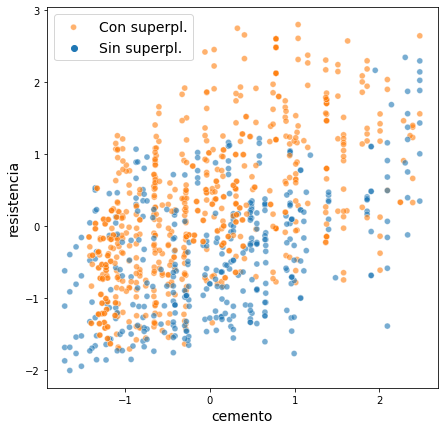

In [52]:
fig, ax = plt.subplots( figsize=(7,7) )

# Observaciones
sns.scatterplot( x=x1, y=y, hue=x2, ax=ax, alpha=.6 )
ax.legend( loc='upper left' )

# Formateo
ax.legend(['Con superpl.','Sin superpl.'], fontsize=14)
ax.set_xlabel('cemento', fontsize=14)
ax.set_ylabel('resistencia', fontsize=14);

Primero ajustamos un modelo sin término de interacción (ni variables índice)

In [54]:
# modelo sin interacción
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 + beta2 * x2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace = pm.sample( 3000, tune=2000, cores=2 )

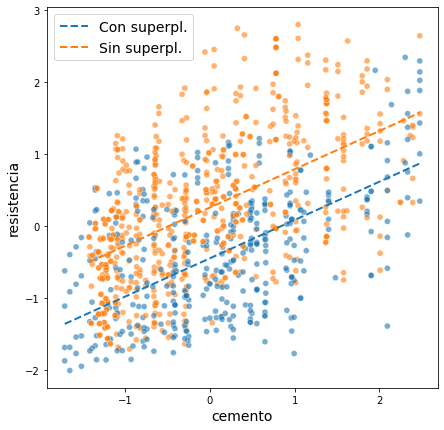

In [55]:
fig, ax = plt.subplots( figsize=(7,7) )

# Observaciones
sns.scatterplot( x=x1, y=y, hue=x2, ax=ax, alpha=.6 )
ax.legend( loc='upper left' )

# Línea media
mu_mean = trace.posterior['mu'].mean(['chain','draw'])

ix = np.argsort(x1[x2==0])
ax.plot( x1[x2==0][ix], mu_mean[x2==0][ix],
         linestyle='--', color='C0', linewidth=2 )

ix = np.argsort(x1[x2==1])
ax.plot( x1[x2==1][ix], mu_mean[x2==1][ix],
         linestyle='--', color='C1', linewidth=2 )

# Formateo
ax.legend(['Con superpl.','Sin superpl.'], fontsize=14)
ax.set_xlabel('cemento', fontsize=14)
ax.set_ylabel('resistencia', fontsize=14);

Luego ajustamos el modelo con la variable binaria como variable índice, o con un término de interacción (es lo mismo!)

In [56]:
# modelo con variable índice o con término de interacción
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2, shape=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2, shape=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0[ x2 ] + beta1[ x2 ] * x1 )
    # mu = pm.Deterministic('mu', beta0[0] + beta0[1] * x1 + beta1[0] * x2 + beta1[1] * x1 * x2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace = pm.sample( 3000, tune=2000, cores=2 )

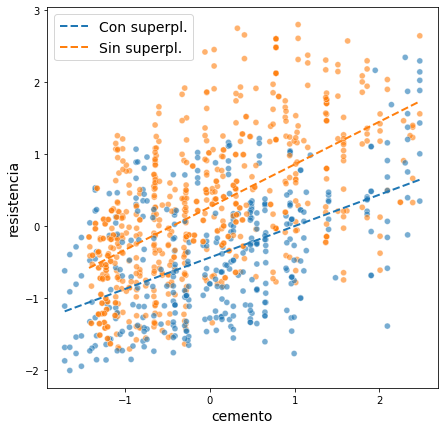

In [57]:
fig, ax = plt.subplots( figsize=(7,7) )

# Observaciones
sns.scatterplot( x=x1, y=y, hue=x2, ax=ax, alpha=.6 )
ax.legend( loc='upper left' )

# Línea media
mu_mean = trace.posterior['mu'].mean(['chain','draw'])

ix = np.argsort(x1[x2==0])
ax.plot( x1[x2==0][ix], mu_mean[x2==0][ix],
         linestyle='--', color='C0', linewidth=2 )

ix = np.argsort(x1[x2==1])
ax.plot( x1[x2==1][ix], mu_mean[x2==1][ix],
         linestyle='--', color='C1', linewidth=2 )

# Formateo
ax.legend(['Con superpl.','Sin superpl.'], fontsize=14)
ax.set_xlabel('cemento', fontsize=14)
ax.set_ylabel('resistencia', fontsize=14);

## Ejemplo 6: Interacción variable continua y categórica

Se realiza una regresión con itneracicón del período natural de los galpones versus la altura y la tipología estructural

In [58]:
x1 = df_galpones['Height_in_'].to_numpy()
x1 = (x1-x1.mean())/x1.std()
x2 = df_galpones['tipologia_cod'].to_numpy()
y = df_galpones['T_model_s_'].to_numpy()
y = (y-y.mean())/y.std()

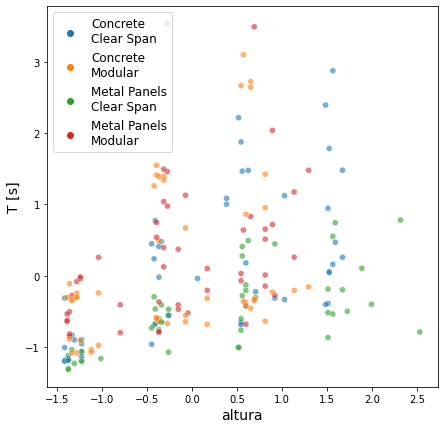

In [59]:
fig, ax = plt.subplots( figsize=(7,7) )

# Observaciones
sns.scatterplot( x=x1, y=y, hue=df_galpones['tipologia'], ax=ax, alpha=.6 )

# Formateo
ax.legend( loc='upper left', fontsize=12 )
ax.set_xlabel('altura', fontsize=14)
ax.set_ylabel('T [s]', fontsize=14);

In [60]:
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2, shape=4 )
    beta = pm.Normal( "beta", mu=0, sigma=2, shape=4 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0[x2] + beta[x2] * x1 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace = pm.sample( 3000, tune=2000, cores=2 )

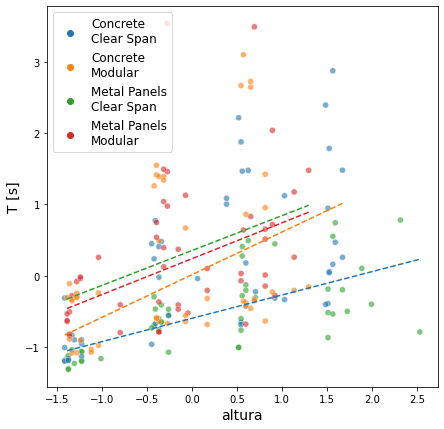

In [61]:
fig, ax = plt.subplots( figsize=(7,7) )

# Observaciones
sns.scatterplot( x=x1, y=y, hue=df_galpones['tipologia'], ax=ax, alpha=.6 )

# Línea media
mu_mean = trace.posterior['mu'].mean(['chain','draw'])

# Lineas medias
for i in range(4):
    ix = np.argsort(x1[x2==i])
    ax.plot( x1[x2==i][ix], mu_mean[x2==i][ix],
             linestyle='--', color='C'+str(i) )

# Formateo
ax.legend( loc='upper left', fontsize=12 )
ax.set_xlabel('altura', fontsize=14)
ax.set_ylabel('T [s]', fontsize=14);

## Ejemplo 7: Correlación espúrea

In [62]:
# Observaciones sintéticas
N = 100
x1 = st.uniform.rvs( size=N, loc=-2, scale=4 )
x2 = st.norm.rvs( size=N, loc=x1-1, scale=0.9 )
y = st.norm.rvs( size=N, loc=1+0.5*x1, scale=0.5 )

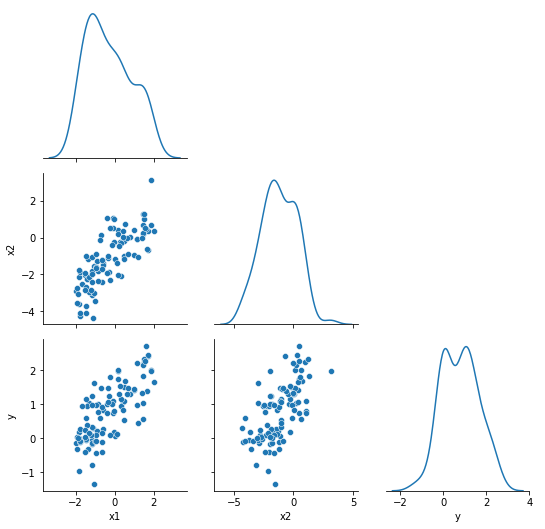

In [63]:
g = sns.PairGrid( pd.DataFrame({'x1':x1,'x2':x2,'y':y,}),
                  diag_sharey=False, corner=True, vars=['x1','x2','y'])
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend();

In [64]:
# modelo solo con x1
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1 = pm.sample( 3000, tune=2000, cores=2 )

In [65]:
# modelo solo con x2
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta2 * x2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x2 = pm.sample( 3000, tune=2000, cores=2 )

In [66]:
# modelo con x1 y x2
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 + beta2 * x2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1x2 = pm.sample( 3000, tune=2000, cores=2 )

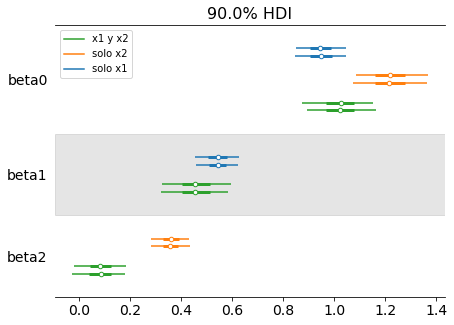

In [67]:
az.plot_forest( [trace_x1,trace_x2,trace_x1x2], var_names=['~mu','~sigma'],
                model_names=['solo x1','solo x2','x1 y x2'],
                figsize=(7,5), textsize=14, hdi_prob=0.9 );

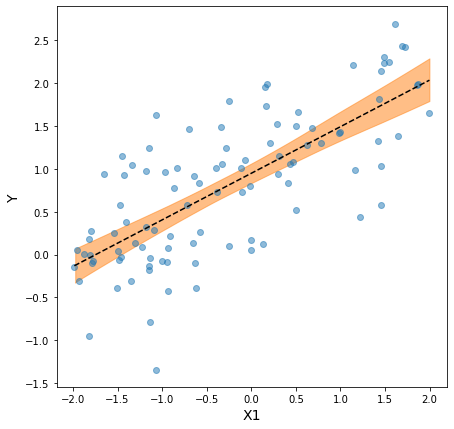

In [68]:
fig, ax = plt.subplots( figsize=(7,7) )
# índice para ordenar en orden creciente obsrevaciones de x
ix = np.argsort(x1)
# Línea media
ax.plot( x1[ix], trace_x1.posterior['mu'].mean(['chain','draw'])[ix],'k--')
# HDI de mu
az.plot_hdi( x1, trace_x1.posterior['mu'], color='C1', ax=ax )
# Observaciones
ax.scatter( x1, y, alpha=.5 )
# Formateo
ax.set_xlabel('X1', fontsize=14)
ax.set_ylabel('Y', fontsize=14);

## Ejemplo 8: Relación enmascarada

In [69]:
# Observaciones sintéticas
N = 100
x1 = st.norm.rvs( size=N, loc=0, scale=1 )
x2 = st.norm.rvs( size=N, loc=x1, scale=1 )
y = st.norm.rvs( size=N, loc=x1-x2, scale=1 )

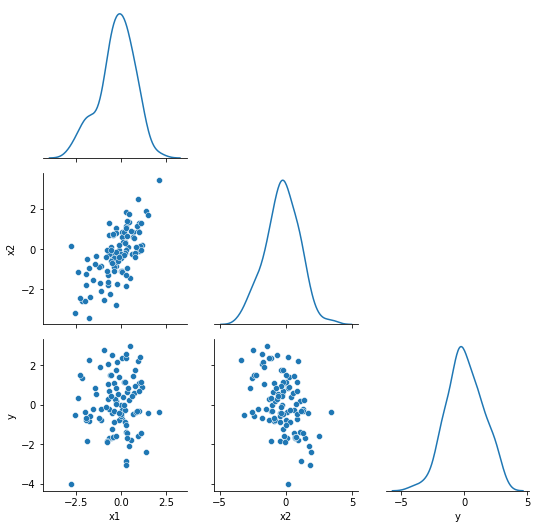

In [70]:
g = sns.PairGrid( pd.DataFrame({'x1':x1,'x2':x2,'y':y,}),
                  diag_sharey=False, corner=True, vars=['x1','x2','y'])
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend();

In [71]:
# modelo solo con x1
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1 = pm.sample( 3000, tune=2000, cores=2 )

In [72]:
# modelo solo con x2
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta2 * x2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x2 = pm.sample( 3000, tune=2000, cores=2 )

In [73]:
# modelo con x1 y x2
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 + beta2 * x2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1x2 = pm.sample( 3000, tune=2000, cores=2 )

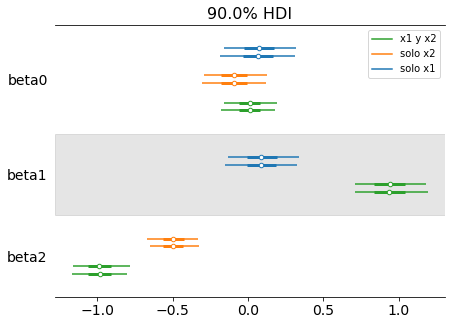

In [74]:
az.plot_forest( [trace_x1,trace_x2,trace_x1x2], var_names=['~mu','~sigma'],
                model_names=['solo x1','solo x2','x1 y x2'],
                figsize=(7,5), textsize=14, hdi_prob=0.9 );

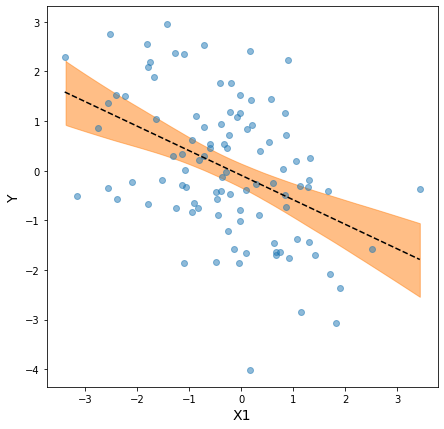

In [75]:
fig, ax = plt.subplots( figsize=(7,7) )
# índice para ordenar en orden creciente obsrevaciones de x
ix = np.argsort(x2)
# Línea media
ax.plot( x2[ix], trace_x2.posterior['mu'].mean(['chain','draw'])[ix],'k--')
# HDI de mu
az.plot_hdi( x2, trace_x2.posterior['mu'], color='C1', ax=ax )
# Observaciones
ax.scatter( x2, y, alpha=.5 )
# Formateo
ax.set_xlabel('X1', fontsize=14)
ax.set_ylabel('Y', fontsize=14);

## Ejemplo 9: Simpson's paradox

El siguiente código genera un dataset sintético que simula la condición de relación enmascarada clásica de la paradoja de Simpson.

Ref: http://www.degeneratestate.org/posts/2017/Oct/22/generating-examples-of-simpsons-paradox/

In [77]:
def generate_gaussian_simpsons_paradox(n_subgroups=5, n_samples=1000):

    overall_cov = 3*np.array([[1,0.9], [0.9,1]])

    means = np.random.multivariate_normal(mean=[0,0], cov=overall_cov, size=n_subgroups)
    
    weights = np.random.uniform(size=n_subgroups)
    weights /= np.sum(weights)
    covs = [np.random.uniform(0.2,0.8) for _ in range(n_subgroups)]
    covs = [np.array([[1,-c], [-c,1]]) for c in covs]

    samples = []

    for sg, (mean, cov, w) in enumerate(zip(means, covs, weights)):
        n = int(round(n_samples * w))
        sample = np.random.multivariate_normal(mean=mean, cov=cov, size=n)
        sample = pd.DataFrame(sample, columns=["x1", "y"])
        sample["x2"] = sg
        samples.append(sample)
        
    df = pd.concat(samples)
    
    return df

df_simpson = generate_gaussian_simpsons_paradox()
df_simpson.head()

,x1,y,x2
0,0.514475,-0.954817,0
1,1.265892,-1.644126,0
2,1.329425,-1.570305,0
3,0.840441,-0.237818,0
4,0.725440,0.283903,0


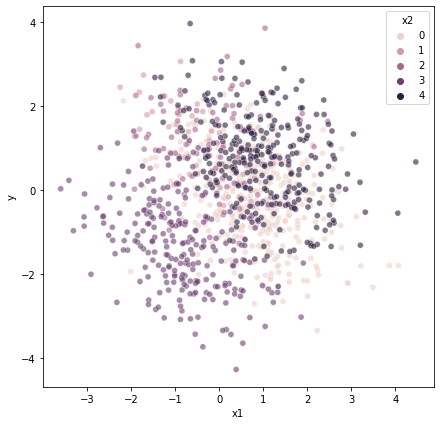

In [78]:
fig, ax = plt.subplots( figsize=(7,7) )
# Observaciones
sns.scatterplot( data=df_simpson, x='x1', y='y', hue='x2', ax=ax, alpha=.6 );

In [79]:
x1 = df_simpson['x1'].to_numpy()
x2 = df_simpson['x2'].to_numpy()
y = df_simpson['y'].to_numpy()

In [80]:
# modelo solo con x1
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1 = pm.sample( 3000, tune=2000, cores=2 )

In [81]:
# modelo con x1 y x2 con interacción
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2, shape=5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2, shape=5 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0[ x2 ] + beta1[ x2 ] * x1 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1x2 = pm.sample( 3000, tune=2000, cores=2 )

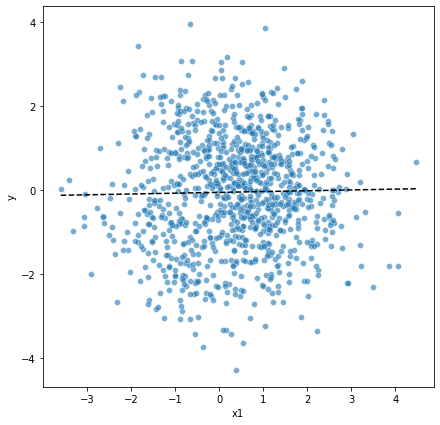

In [82]:
# Ajuste del modelo solo con x1
fig, ax = plt.subplots( figsize=(7,7) )

# Observaciones
sns.scatterplot( data=df_simpson, x='x1', y='y', ax=ax, alpha=.6 )

# Línea media
mu_mean = trace_x1.posterior['mu'].mean(['chain','draw'])
ix = np.argsort(x1)
ax.plot( x1[ix], mu_mean[ix], color='k', linestyle='--');

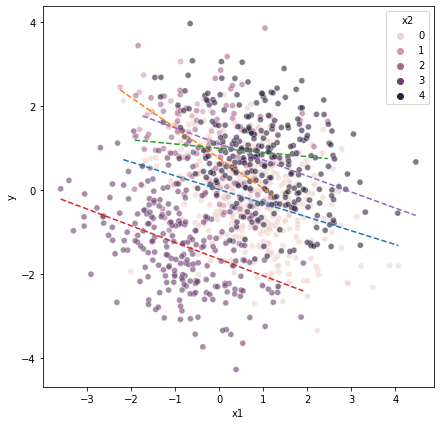

In [83]:
# Ajuste del modelo con x1 y x2 con interacción

fig, ax = plt.subplots( figsize=(7,7) )

# Observaciones
sns.scatterplot( data=df_simpson, x='x1', y='y', hue='x2', ax=ax, alpha=.6 )

# Línea media
mu_mean = trace_x1x2.posterior['mu'].mean(['chain','draw'])

# Lineas medias
for i in range(5):
    ix = np.argsort(x1[x2==i])
    ax.plot( x1[x2==i][ix], mu_mean[x2==i][ix],
             linestyle='--', color='C'+str(i) )

## Ejemplo 10: sesgo por efecto comun (collider bias)

In [86]:
# Observaciones sintéticas
N = 100
x1 = st.norm.rvs( size=N, loc=0, scale=1 )
y = st.norm.rvs( size=N, loc=0, scale=1 )
x2 = st.norm.rvs( size=N, loc=x1+y, scale=1 )

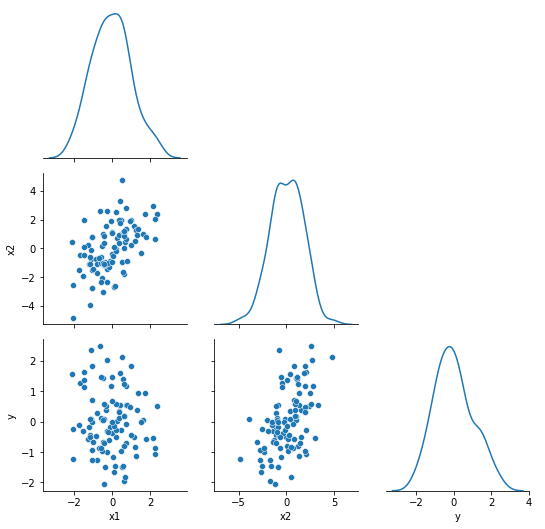

In [87]:
g = sns.PairGrid( pd.DataFrame({'x1':x1,'x2':x2,'y':y,}),
                  diag_sharey=False, corner=True, vars=['x1','x2','y'])
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend();

In [88]:
# modelo solo con x1
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1 = pm.sample( 3000, tune=2000, cores=2 )

In [89]:
# modelo solo con x2
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta2 * x2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x2 = pm.sample( 3000, tune=2000, cores=2 )

In [90]:
# modelo con x1 y x2
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 + beta2 * x2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1x2 = pm.sample( 3000, tune=2000, cores=2 )

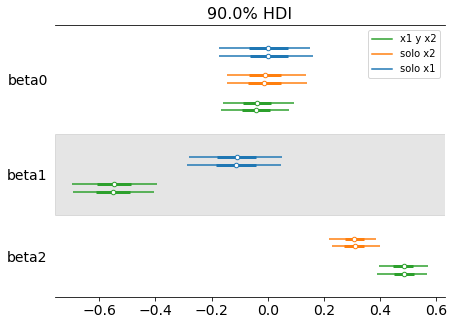

In [91]:
az.plot_forest( [trace_x1,trace_x2,trace_x1x2], var_names=['~mu','~sigma'],
                model_names=['solo x1','solo x2','x1 y x2'],
                figsize=(7,5), textsize=14, hdi_prob=0.9 );

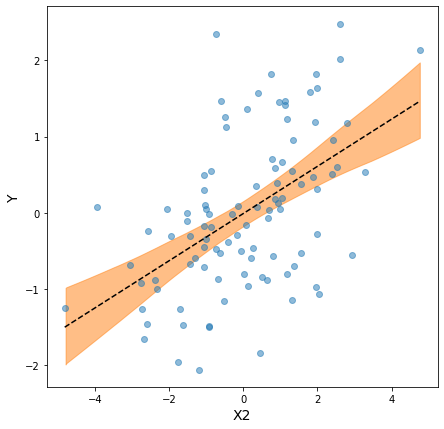

In [92]:
fig, ax = plt.subplots( figsize=(7,7) )
# índice para ordenar en orden creciente obsrevaciones de x
ix = np.argsort(x2)
# Línea media
ax.plot( x2[ix], trace_x2.posterior['mu'].mean(['chain','draw'])[ix],'k--')
# HDI de mu
az.plot_hdi( x2, trace_x2.posterior['mu'], color='C1', ax=ax )
# Observaciones
ax.scatter( x2, y, alpha=.5 )
# Formateo
ax.set_xlabel('X2', fontsize=14)
ax.set_ylabel('Y', fontsize=14);

## Ejemplo 11: observaciones sintéticas para evaluación del ajuste

Si el modelo se ajusta bien a los datos, entonces observaciones generadas por el modelo deberían verse 'similares' a los datos

### Gráfico de regresión

In [93]:
# Observaciones sintéticas
N = 100
x1 = st.norm.rvs( size=N, loc=0, scale=1 )
y = st.norm.rvs( size=N, loc=1+0.5*x1, scale=0.5)

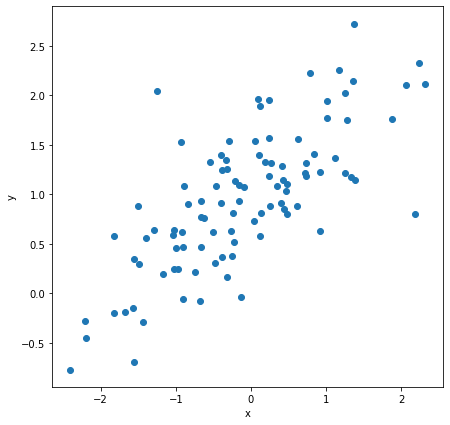

In [94]:
fig, ax = plt.subplots( figsize=(7,7) )
ax.scatter( x1, y )
ax.set_xlabel('x')
ax.set_ylabel('y');

In [95]:
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace, extend_inferencedata=True )

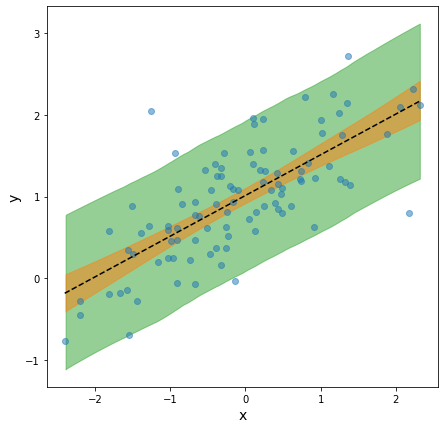

In [102]:
fig, ax = plt.subplots( figsize=(7,7) )

# Línea media
ix = np.argsort(x1)
ax.plot( x1[ix], trace.posterior['mu'].mean(['chain','draw'])[ix],'k--')

# HDI de observaciones
az.plot_hdi( x1, trace.posterior_predictive['y'], color='C2', ax=ax )

# HDI de mu
az.plot_hdi( x1, trace.posterior['mu'], color='C1', ax=ax )

# Observaciones
ax.scatter( x1, y, alpha=.5 )

# Formateo
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14);

### Residuos

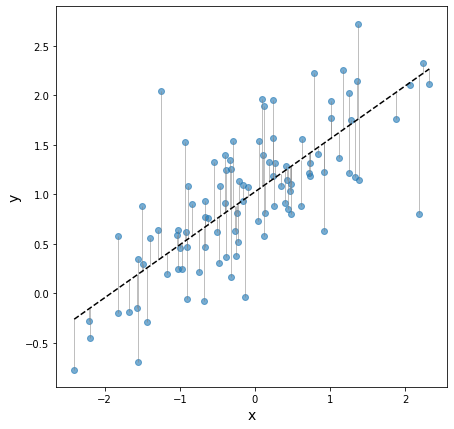

In [103]:
# Recta media cualquiera
recta_i = trace.posterior['mu'][0,15,:]

# índice para ordenar en orden creciente observaciones de x
ix = np.argsort(x1)

# Gráfico
fig, ax = plt.subplots( figsize=(7,7) )
ax.plot( x1[ix], recta_i[ix], 'k--' ) # recta media
ax.scatter( x1, y, color='C0', alpha=.6 ) # observaciones
ax.vlines( x1, recta_i, y, colors='grey', linewidth=1, alpha=.5) # residuos
# Formateo
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14);

In [104]:
# Cálculo de residuos

# Lineas medias
mu_pred = trace.posterior['mu'].stack(sample=("chain", "draw")).to_numpy()

# Residuos
residuals = y - mu_pred.T

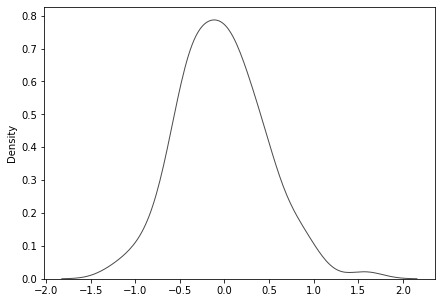

In [108]:
# Histograma de residuos
fig, ax = plt.subplots( figsize=(7,5) )
sns.kdeplot( residuals[100], color='k', alpha=.7, linewidth=1, legend=False, ax=ax );

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  import sys


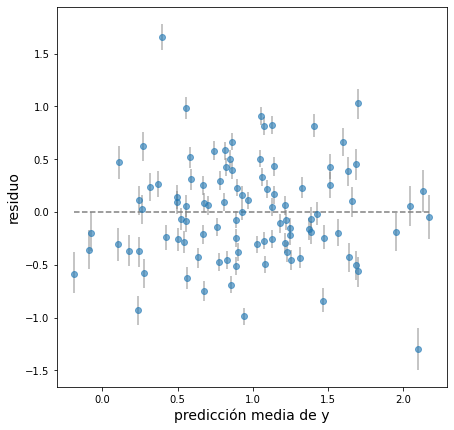

In [109]:
# Residuos vs predicción media

# Predicción posterior media de y
y_mean = trace.posterior_predictive['y'].mean( ['chain','draw'] ).to_numpy()

# Intervalos de confianza
residuals_hdi = az.hdi( residuals, hdi_prob=0.9 )
residuals_mean = np.mean( residuals, 0 );

# Gráfico
fig, ax = plt.subplots( figsize=(7,7) )
ax.hlines( y=0, xmin=y_mean.min(), xmax=y_mean.max(),
            colors='grey', linestyle='--' )
ax.errorbar( y_mean, residuals_mean,
             yerr=np.abs(residuals_mean-residuals_hdi.T ),
             fmt='C0o',
             ecolor='grey', alpha=.6 )

# Formateo
ax.set_xlabel('predicción media de y', fontsize=14)
ax.set_ylabel('residuo', fontsize=14);

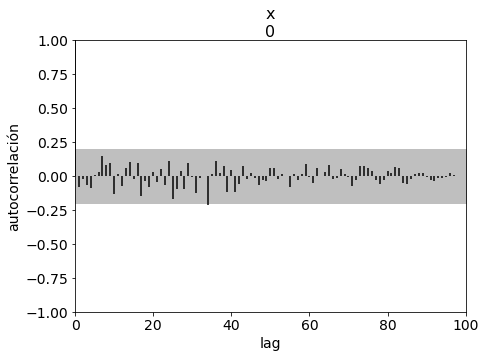

In [110]:
fig, ax = plt.subplots( figsize=(7,5) )
az.plot_autocorr( residuals[20], ax=ax )
# Formateo
ax.set_xlabel('lag', fontsize=14)
ax.set_ylabel('autocorrelación', fontsize=14);

### Predicciones posteriores

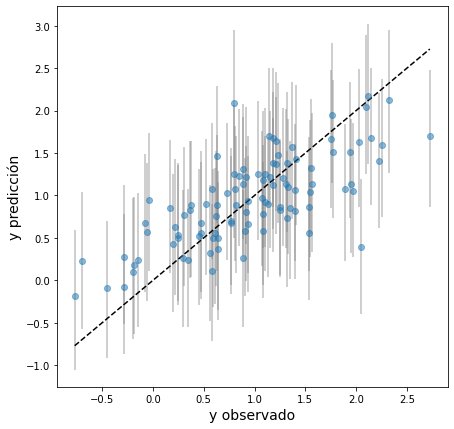

In [111]:
# Predicciones posteriores
    
# Obsrevaciones
y_observed = trace.observed_data['y']
# HDI intervalo de confianza de mu
mu_hdi = az.hdi( trace.posterior_predictive['y'], hdi_prob=0.9 )
# Media de observaciones
y_mean = trace.posterior_predictive['y'].mean( ['chain','draw'] ).to_numpy()

fig, ax = plt.subplots( figsize=(7,7) )
    
# recta diagonal
min_x, max_x = y_observed.min(), y_observed.max()
ax.plot([min_x, max_x], [min_x, max_x], 'k--')
# Errores
ax.errorbar( y_observed, y_mean,
              yerr=np.abs(y_mean-mu_hdi['y'].T.to_numpy()), fmt='C0o',
              alpha=.5, ecolor='grey' )
# Labels
ax.set_xlabel('y observado', fontsize=14)
ax.set_ylabel('y predicción', fontsize=14);

### Distribución marginal predictiva de y

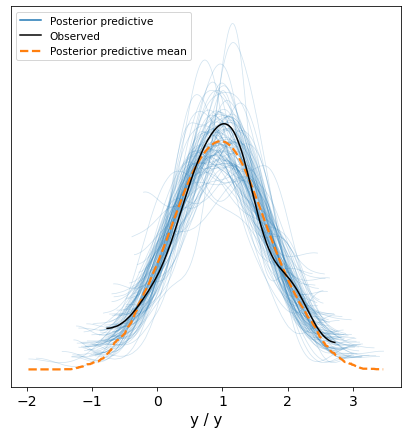

In [112]:
az.plot_ppc( trace, num_pp_samples=100, figsize=(7,7), textsize=14 );

## Ejemplo 12: Multicolinealidad con dataset sintético

In [113]:
# Dataset sintético
N=100
x1 = st.uniform.rvs( size=N, loc=3, scale=5 )
x2 = x1 * 0.5
y = 1 + 2 * x1 + st.norm.rvs( size=N, loc=0, scale=1 )

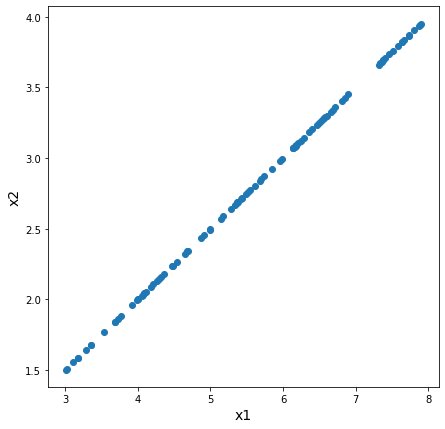

In [114]:
fig, ax = plt.subplots( figsize=(7,7) )
ax.scatter( x1, x2 )
ax.set_xlabel('x1', fontsize=14)
ax.set_ylabel('x2', fontsize=14);

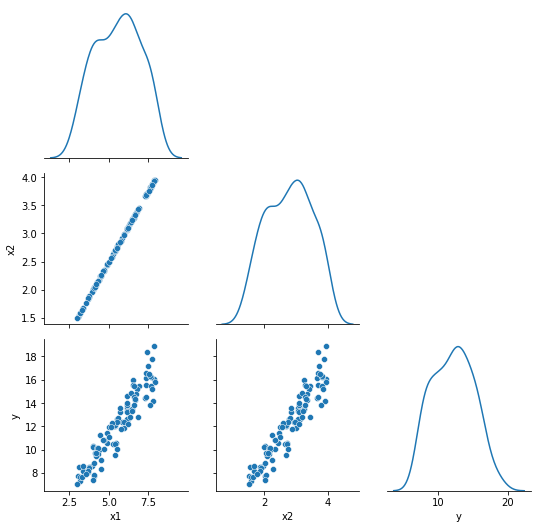

In [115]:
g = sns.PairGrid( pd.DataFrame({'x1':x1,'x2':x2,'y':y,}),
                  diag_sharey=False, corner=True, vars=['x1','x2','y'])
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend();

In [116]:
# modelo solo con x1
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1 = pm.sample( 3000, tune=2000, cores=2 )

In [117]:
# modelo solo con x2
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta2 * x2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x2 = pm.sample( 3000, tune=2000, cores=2 )

In [ ]:
# modelo con x1 y x2
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 + beta2 * x2 )
    b_sum = pm.Deterministic('b_sum', beta1 + beta2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1x2 = pm.sample( 3000, tune=2000, cores=2 )

ERROR:pymc:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


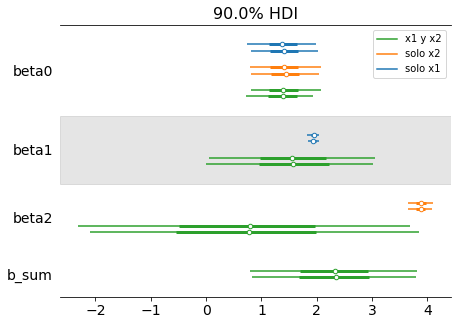

In [ ]:
az.plot_forest( [trace_x1,trace_x2,trace_x1x2], var_names=['~mu','~sigma'],
                model_names=['solo x1','solo x2','x1 y x2'],
                figsize=(7,5), textsize=14, hdi_prob=0.9 );

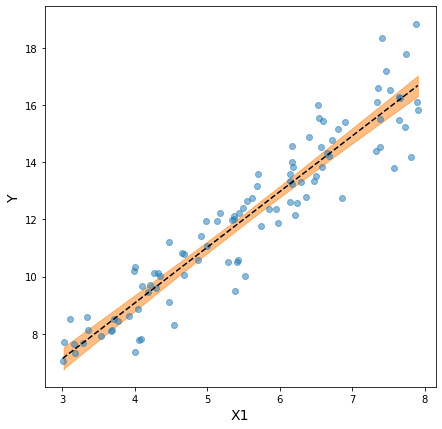

In [118]:
fig, ax = plt.subplots( figsize=(7,7) )
# índice para ordenar en orden creciente obsrevaciones de x
ix = np.argsort(x1)
# Línea media
ax.plot( x1[ix], trace_x1.posterior['mu'].mean(['chain','draw'])[ix],'k--')
# HDI de mu
az.plot_hdi( x1, trace_x1.posterior['mu'], color='C1', ax=ax )
# Observaciones
ax.scatter( x1, y, alpha=.5 )
# Formateo
ax.set_xlabel('X1', fontsize=14)
ax.set_ylabel('Y', fontsize=14);

## Ejemplo 13: Multicolinealidad con dataset de punzonado

Realizamos una regresión de la resistencia al punzonado de la losa versus la altura útil de la losa, y su altura total

In [119]:
x1 = df_punzonado['d(mm)']
x1 = (x1-x1.mean())/x1.std()
x2 = df_punzonado['h(mm)']
x2 = (x2-x2.mean())/x2.std()
y = df_punzonado['Vexp(kN)']
y = (y-y.mean())/y.std()

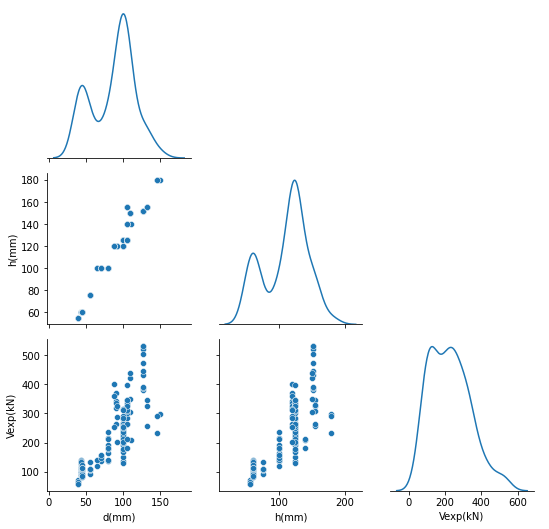

In [120]:
g = sns.PairGrid(df_punzonado, diag_sharey=False, corner=True,
                 vars=['d(mm)',
                       'h(mm)',
                       'Vexp(kN)'])
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend();

In [121]:
# modelo solo con x1
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1 = pm.sample( 3000, tune=2000, cores=2 )

In [122]:
# modelo solo con x2
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta2 * x2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x2 = pm.sample( 3000, tune=2000, cores=2 )

In [123]:
# modelo con x1 y x2
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x1 + beta2 * x2 )
    b_sum = pm.Deterministic('b_sum', beta1 + beta2 )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_x1x2 = pm.sample( 3000, tune=2000, cores=2 )

ERROR:pymc:There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


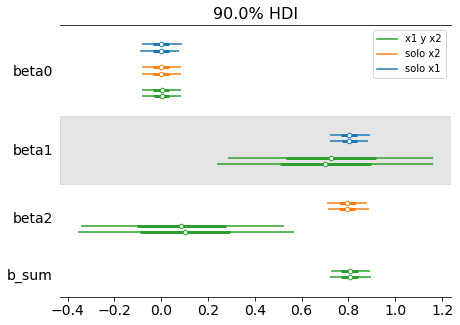

In [124]:
az.plot_forest( [trace_x1,trace_x2,trace_x1x2], var_names=['~mu','~sigma'],
                model_names=['solo x1','solo x2','x1 y x2'],
                figsize=(7,5), textsize=14, hdi_prob=0.9 );